In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import tiktoken
import torch

tokenizer = tiktoken.get_encoding("cl100k_base")
batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[11769,  5149, 11031,   499],
        [11769,  1938, 10187,   264]])


In [ ]:
from dummy_model import DummyGPTModel, load_yaml

torch.manual_seed(123)
config = load_yaml("config/model_config.yaml")["model"]
print(config)

{'vocab_size': 100257, 'context_length': 1024, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': False}


In [9]:
model = DummyGPTModel(config)
logits = model(batch)
print(f"Output shape: {logits.shape}")
print(logits)

Output shape: torch.Size([2, 4, 100257])
tensor([[[ 0.8418, -0.4664,  0.5786,  ..., -0.3249, -0.2455,  0.5239],
         [ 0.2995, -0.0762,  0.4211,  ..., -0.8786,  0.2300,  0.3583],
         [-0.4961,  0.8719, -0.3195,  ..., -1.9143,  0.7710,  1.7108],
         [-2.3610, -0.6406, -0.7998,  ...,  0.5117,  1.8378, -0.4562]],

        [[ 0.9824, -0.4634,  0.4056,  ..., -0.8071, -0.7274,  0.5762],
         [-0.2044,  1.1068, -0.3592,  ..., -0.1660,  0.0834, -0.1185],
         [-0.8517,  0.1915, -0.6877,  ..., -1.0020,  0.7466,  0.6975],
         [-2.7446, -0.7935, -1.0804,  ...,  0.3839,  1.4167,  0.7417]]],
       grad_fn=<UnsafeViewBackward0>)


Output tensor has two rows corresponding to the text text samples, four tokens (rows), and 100257 dimensional-vector (tokenizer vocab size)

## Normalizing activations with layer normalizations

The idea behind layer norm is to have the activations of a nn have a mean of 0 and variance of 1.
Typically applied before and after the multi-head attention module, and before the output layer.

In [2]:
# create 2 training examples with 5 dimensions each
import torch.nn as nn
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [11]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print(mean)
print(var)

tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [12]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print(out_norm)
print(f"mean: {mean}")
print(f"var: {var}")

tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
mean: tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
var: tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [13]:
torch.set_printoptions(sci_mode=False)
print(mean)

tensor([[0.0000],
        [0.0000]], grad_fn=<MeanBackward1>)


### Using Layer norm module

In [15]:
from layer_norm import LayerNorm

ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print(mean)
print(var)

tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


# GELU activation

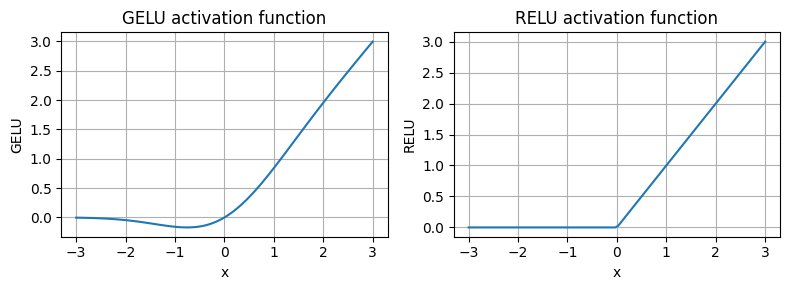

In [18]:
from gelu import GELU
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "RELU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}")
    plt.grid(True)
plt.tight_layout()
plt.show()